# Agent Runs - Evaluation

In this guide, we build a simple agent which can use two tools.  
We run the agent against a couple of user queries and monitor the agent runs via Literal AI.  
Finally, we retrieve the agent runs and check the number of tools they called.

- [Necessary imports](#imports)
- [Create an agent prompt](#create-agent-prompt)
- [Define Available tools](#define-available-tools)
- [Agent logic](#agent-logic)
- [Run agent against two questions](#run-agent)
- [Create a dataset of agent runs](#create-dataset)
- [Evaluate agent runs](#evaluate-agent-runs)

<a id="imports"></a>
## Necessary imports

Make sure to define the `LITERAL_API_KEY` and `OPENAI_API_KEY` in your `.env`.

In [1]:
from literalai import LiteralClient
from dotenv import load_dotenv
from openai import OpenAI

import asyncio
import json

load_dotenv()

literalai_client = LiteralClient()
openai_client = OpenAI()

literalai_client.instrument_openai()

<a id="create-agent-prompt"></a>
## Create agent prompt

This prompt template is the starting prompt for our agent.  
It simply passes on the user's question and mentions that the assistant should be mindful of the tools at its disposal.

In [2]:
PROMPT_NAME = "Agent prompt template"
template_messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant that always answers questions. Keep it short. Answer the question if you can, otherwise leverage tools at your disposal."
    },
    {
        "role": "user",
        "content": "{{question}}"
    }
]
prompt = literalai_client.api.get_or_create_prompt(name=PROMPT_NAME, template_messages=template_messages)

<a id="define-available-tools"></a>
## Define available tools

In the next cell, we define the tools, and their JSON definitions, which we provide to the agent. We have two tools:
- `get_current_weather`
- `get_home_town`

We annotate the two functions with Literal AI `step` decorators of type `tool`, which allows us to easily monitor the tool calls made by our agent. We can evaluate on the number of tool calls and their type.

In [4]:
@literalai_client.step(type="tool")
async def get_current_weather(location, unit="Fahrenheit"):
    """Get the current weather in a given location."""
    weather_info = {
        "location": location,
        "temperature": "72",
        "unit": unit,
        "forecast": ["sunny", "windy"],
    }

    return json.dumps(weather_info)

@literalai_client.step(type="tool")
async def get_home_town(person: str) -> str:
    """Get the hometown of a person"""
    return "Ajaccio, Corsica"


"""
JSON tool definitions provided to the LLM.
"""
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_home_town",
            "description": "Get the home town of a specific person",
            "parameters": {
                "type": "object",
                "properties": {
                    "person": {
                        "type": "string",
                        "description": "The name of a person (first and last names) to identify."
                    }
                },
                "required": ["person"]
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Get the current weather in a given location",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city and state, e.g. San Francisco, CA",
                    },
                    "unit": {"type": "string", "enum": ["celsius", "fahrenheit"]},
                },
                "required": ["location"],
            },
        },
    }
]

<a id="agent-logic"></a>
## Agent logic

For the agent logic, we simply repeat the following pattern (max. 5 times):
- ask the user question to the LLM, making the tools available
- execute tools if LLM asks for it, otherwise return message

In [5]:
async def run_multiple(tool_calls):
    """
    Execute multiple tool calls asynchronously.
    """
    available_tools = {
        "get_current_weather": get_current_weather,
        "get_home_town": get_home_town
    }

    async def run_single(tool_call):
        function_name = tool_call.function.name
        function_to_call = available_tools[function_name]
        function_args = json.loads(tool_call.function.arguments)

        function_response = await function_to_call(**function_args)
        return {
            "tool_call_id": tool_call.id,
            "role": "tool",
            "name": function_name,
            "content": function_response,
        }

    # Run tool calls in parallel.
    tool_results = await asyncio.gather(
        *(run_single(tool_call) for tool_call in tool_calls)
    )
    return tool_results

@literalai_client.step(type="run", tags=["to_score"])
async def run_agent(user_query: str):
    number_iterations = 0
    messages = prompt.format_messages(question=user_query)

    answer_message_content = None

    while number_iterations < 5:
        completion = openai_client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            tool_choice="auto",
            tools=tools
        )
        message = completion.choices[0].message
        messages.append(message)
        answer_message_content = message.content
        
        if not message.tool_calls:
            break

        tool_results = await run_multiple(message.tool_calls)
        messages.extend(tool_results)
        
        number_iterations += 1
    return answer_message_content

<a id="run-agent"></a>
## Run agent against two questions

In [7]:
"""
First question should make 2 calls (one to get the hometown, the other to get the weather).
Second question should trigger a single tool call. Used to evaluate in the last cell.
"""
questions = [ "What's the weather in Napoleon's hometown?", 
              "What's the weather in Paris, TX?" ]

async def main():
    for idx, question in enumerate(questions):
        with literalai_client.thread(name=f"Question {idx+1}") as thread:
            literalai_client.message(content=question, type="user_message", name="User")
            answer = await run_agent(question)
            literalai_client.message(content=answer, type="assistant_message", name="My Assistant")

await main()

# Network requests by the SDK are performed asynchronously.
# Invoke flush() to guarantee the completion of all requests prior to the process termination.
# WARNING: If you run a continuous server, you should not use this method.
literalai_client.flush()

Here is what the thread details look like from Literal AI:
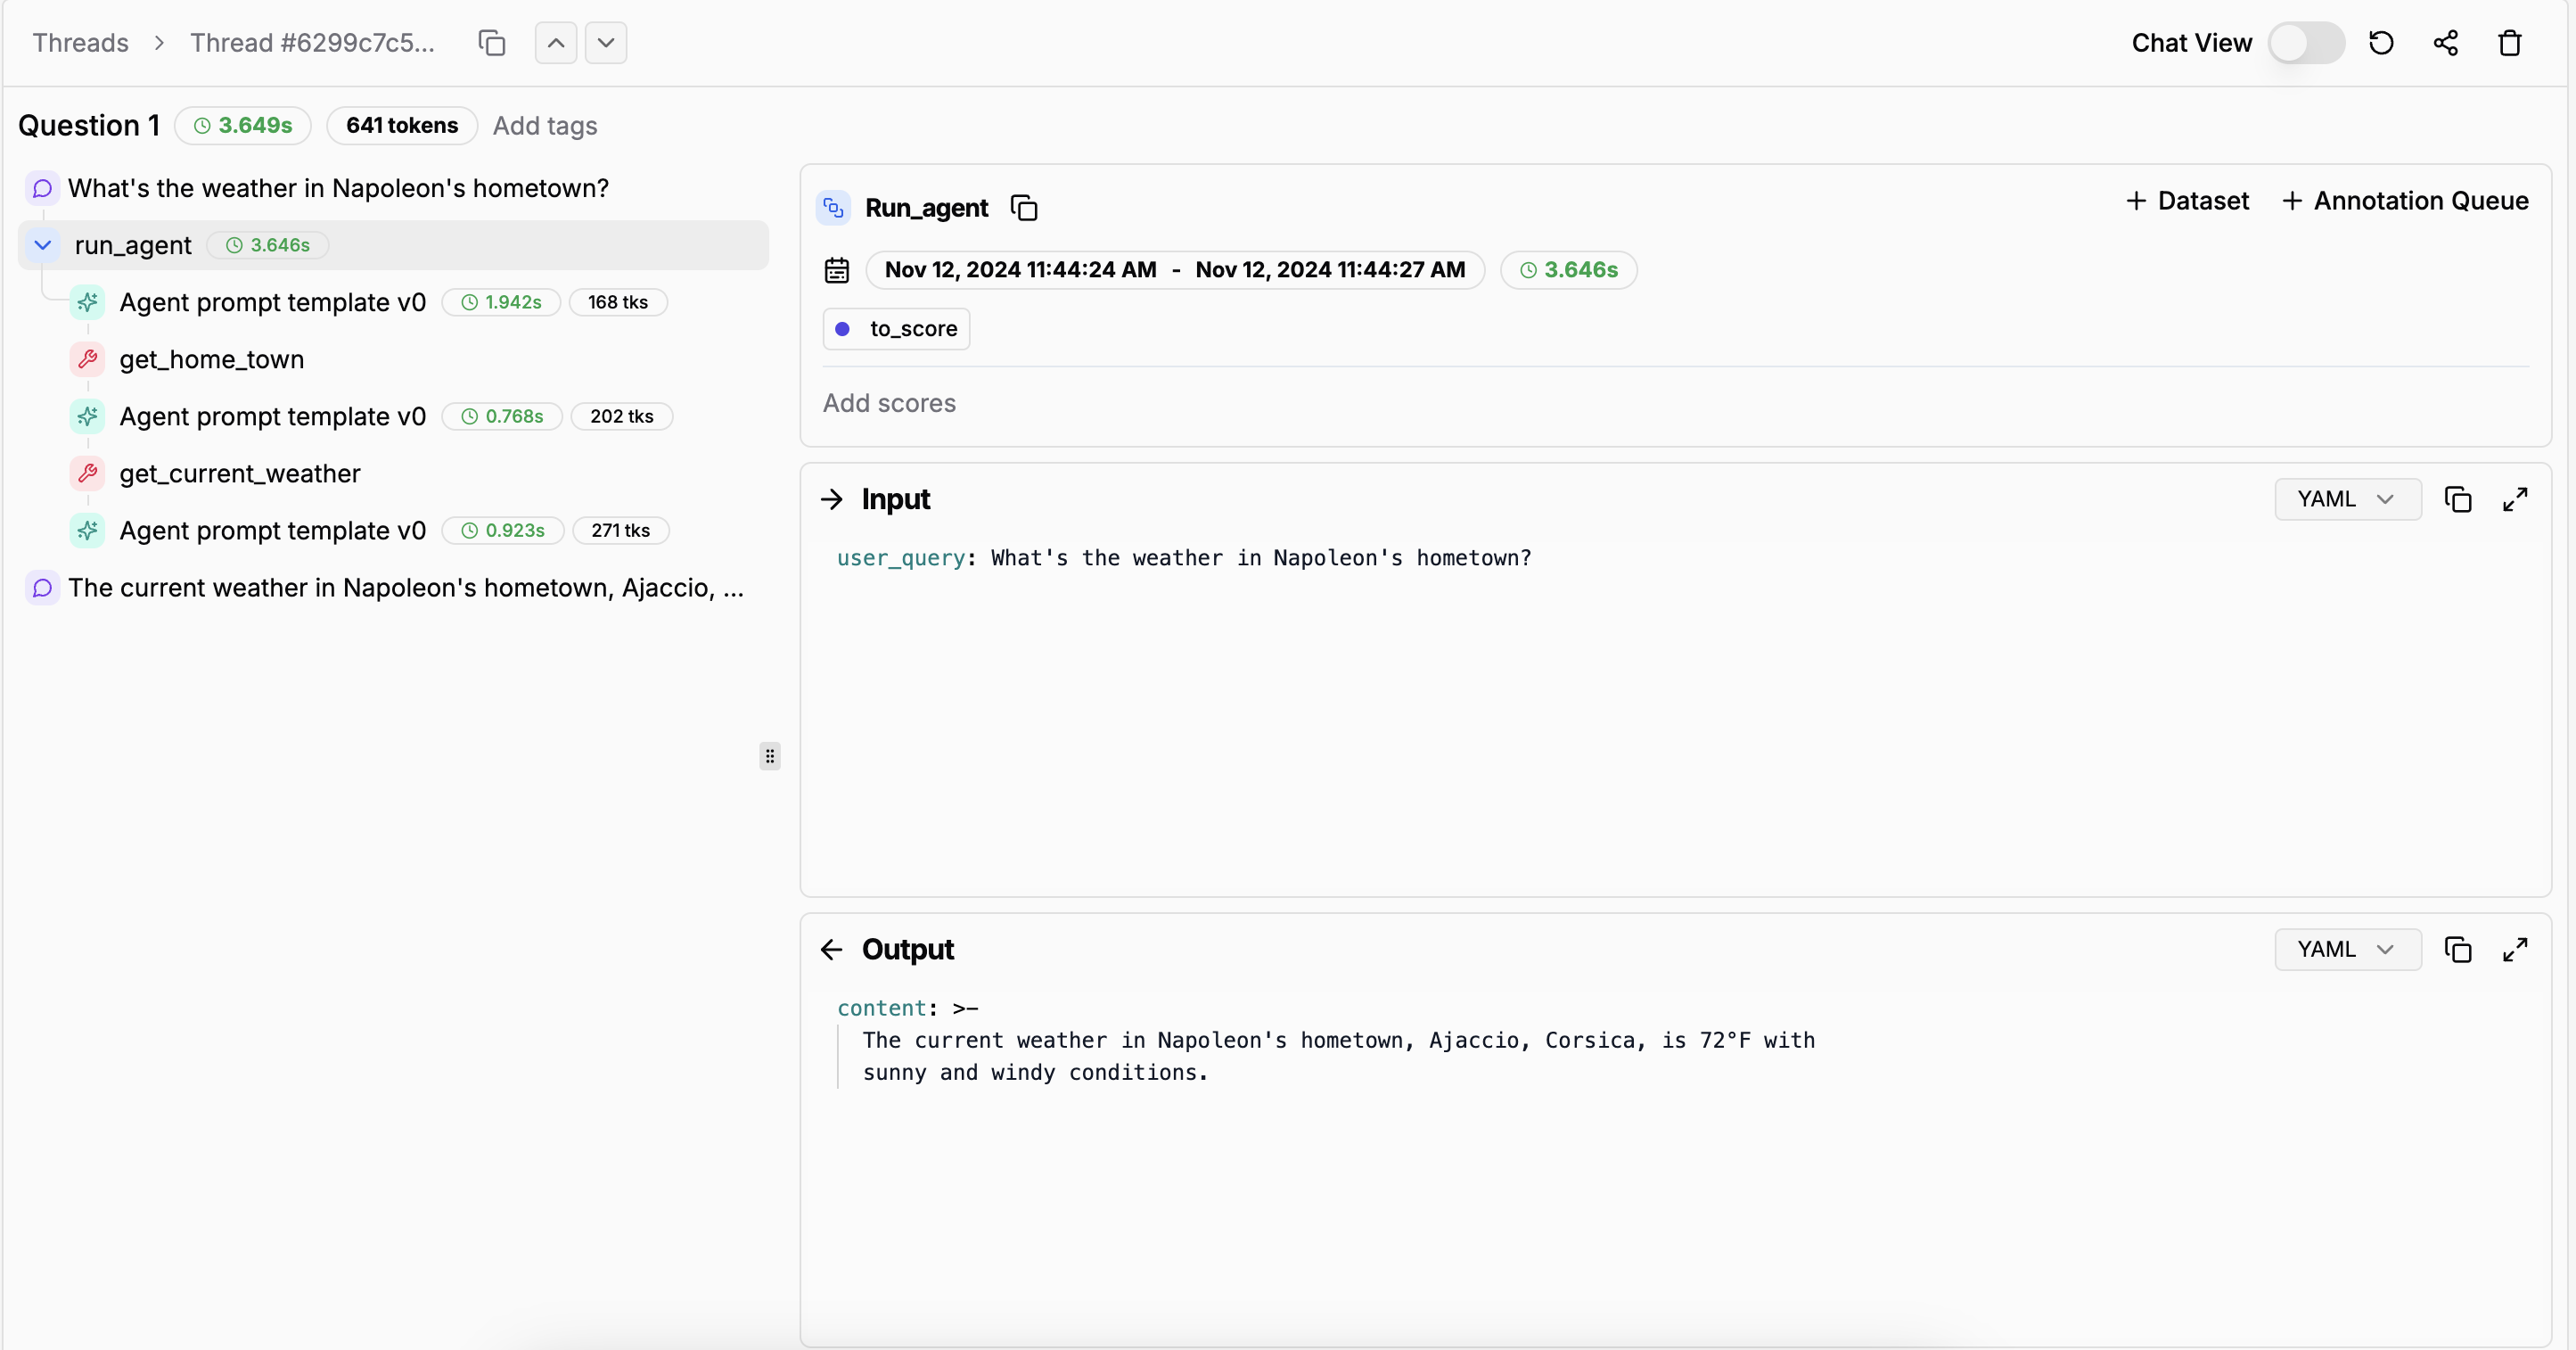

<a id="create-dataset"></a>
## Create a dataset of agent runs

Let's get the two threads corresponding to the two questions we simulated above. 

In [9]:
steps = literalai_client.api.get_steps(filters=[
    {
        "field": "tags",
        "operator": "in",
        "value": ["to_score"]
    },
    {
        "field": "type",
        "operator": "eq",
        "value": "run"
    }]).data

print(f"Number of fetched steps: {len(steps)}")

Number of fetched steps: 2


We add each agent run (step) to a newly created dataset.

In [10]:
dataset = literalai_client.api.create_dataset(name="Agent Runs")

for step in steps:
    dataset.add_step(step_id=step.id)

<a id="evaluate-agent-runs"></a>
## Evaluate agent runs

We can create an experiment referencing the two questions we ran against our agent.  

The Agent is incorrect if it initiates with get_current_weather followed by get_home_town. 


In [11]:
# Check that we respect a certain order in our tool calls: hometown first, then weather.
def is_tool_order_respected(tool_calls):
    call_names = [call["name"] for call in tool_calls]
    hometown_index = call_names.index("get_home_town") if "get_home_town" in call_names else None
    weather_index = call_names.index("get_weather") if "get_weather" in call_names else None
    if hometown_index and weather_index:
        return hometown_index < weather_index
    return True

experiment = dataset.create_experiment(name="Tool use")

for idx, item in enumerate(dataset.items):
    
    intermediary_tool_calls = list(filter(lambda x: x["type"] == "tool", item.intermediary_steps))
    
    scores = [{ 
        "name": "Tool order respected",
        "type": "CODE",
        "value": 1 if is_tool_order_respected(intermediary_tool_calls) else 0
    }]
    
    experiment_item = {
        "datasetItemId": item.id,
        "scores": scores,
        "input": { "question": questions[idx] },
        "output": { "tool_calls": intermediary_tool_calls }
    }
    experiment.log(experiment_item)


The experiment can then serve as a benchmark when making a change to the application (i.e. we can compare to it).

By running the two dataset items inputs against newer versions of your agent, and launching a new experiment, you can
easily compare your runs and quickly take note of the impact on those two questions:

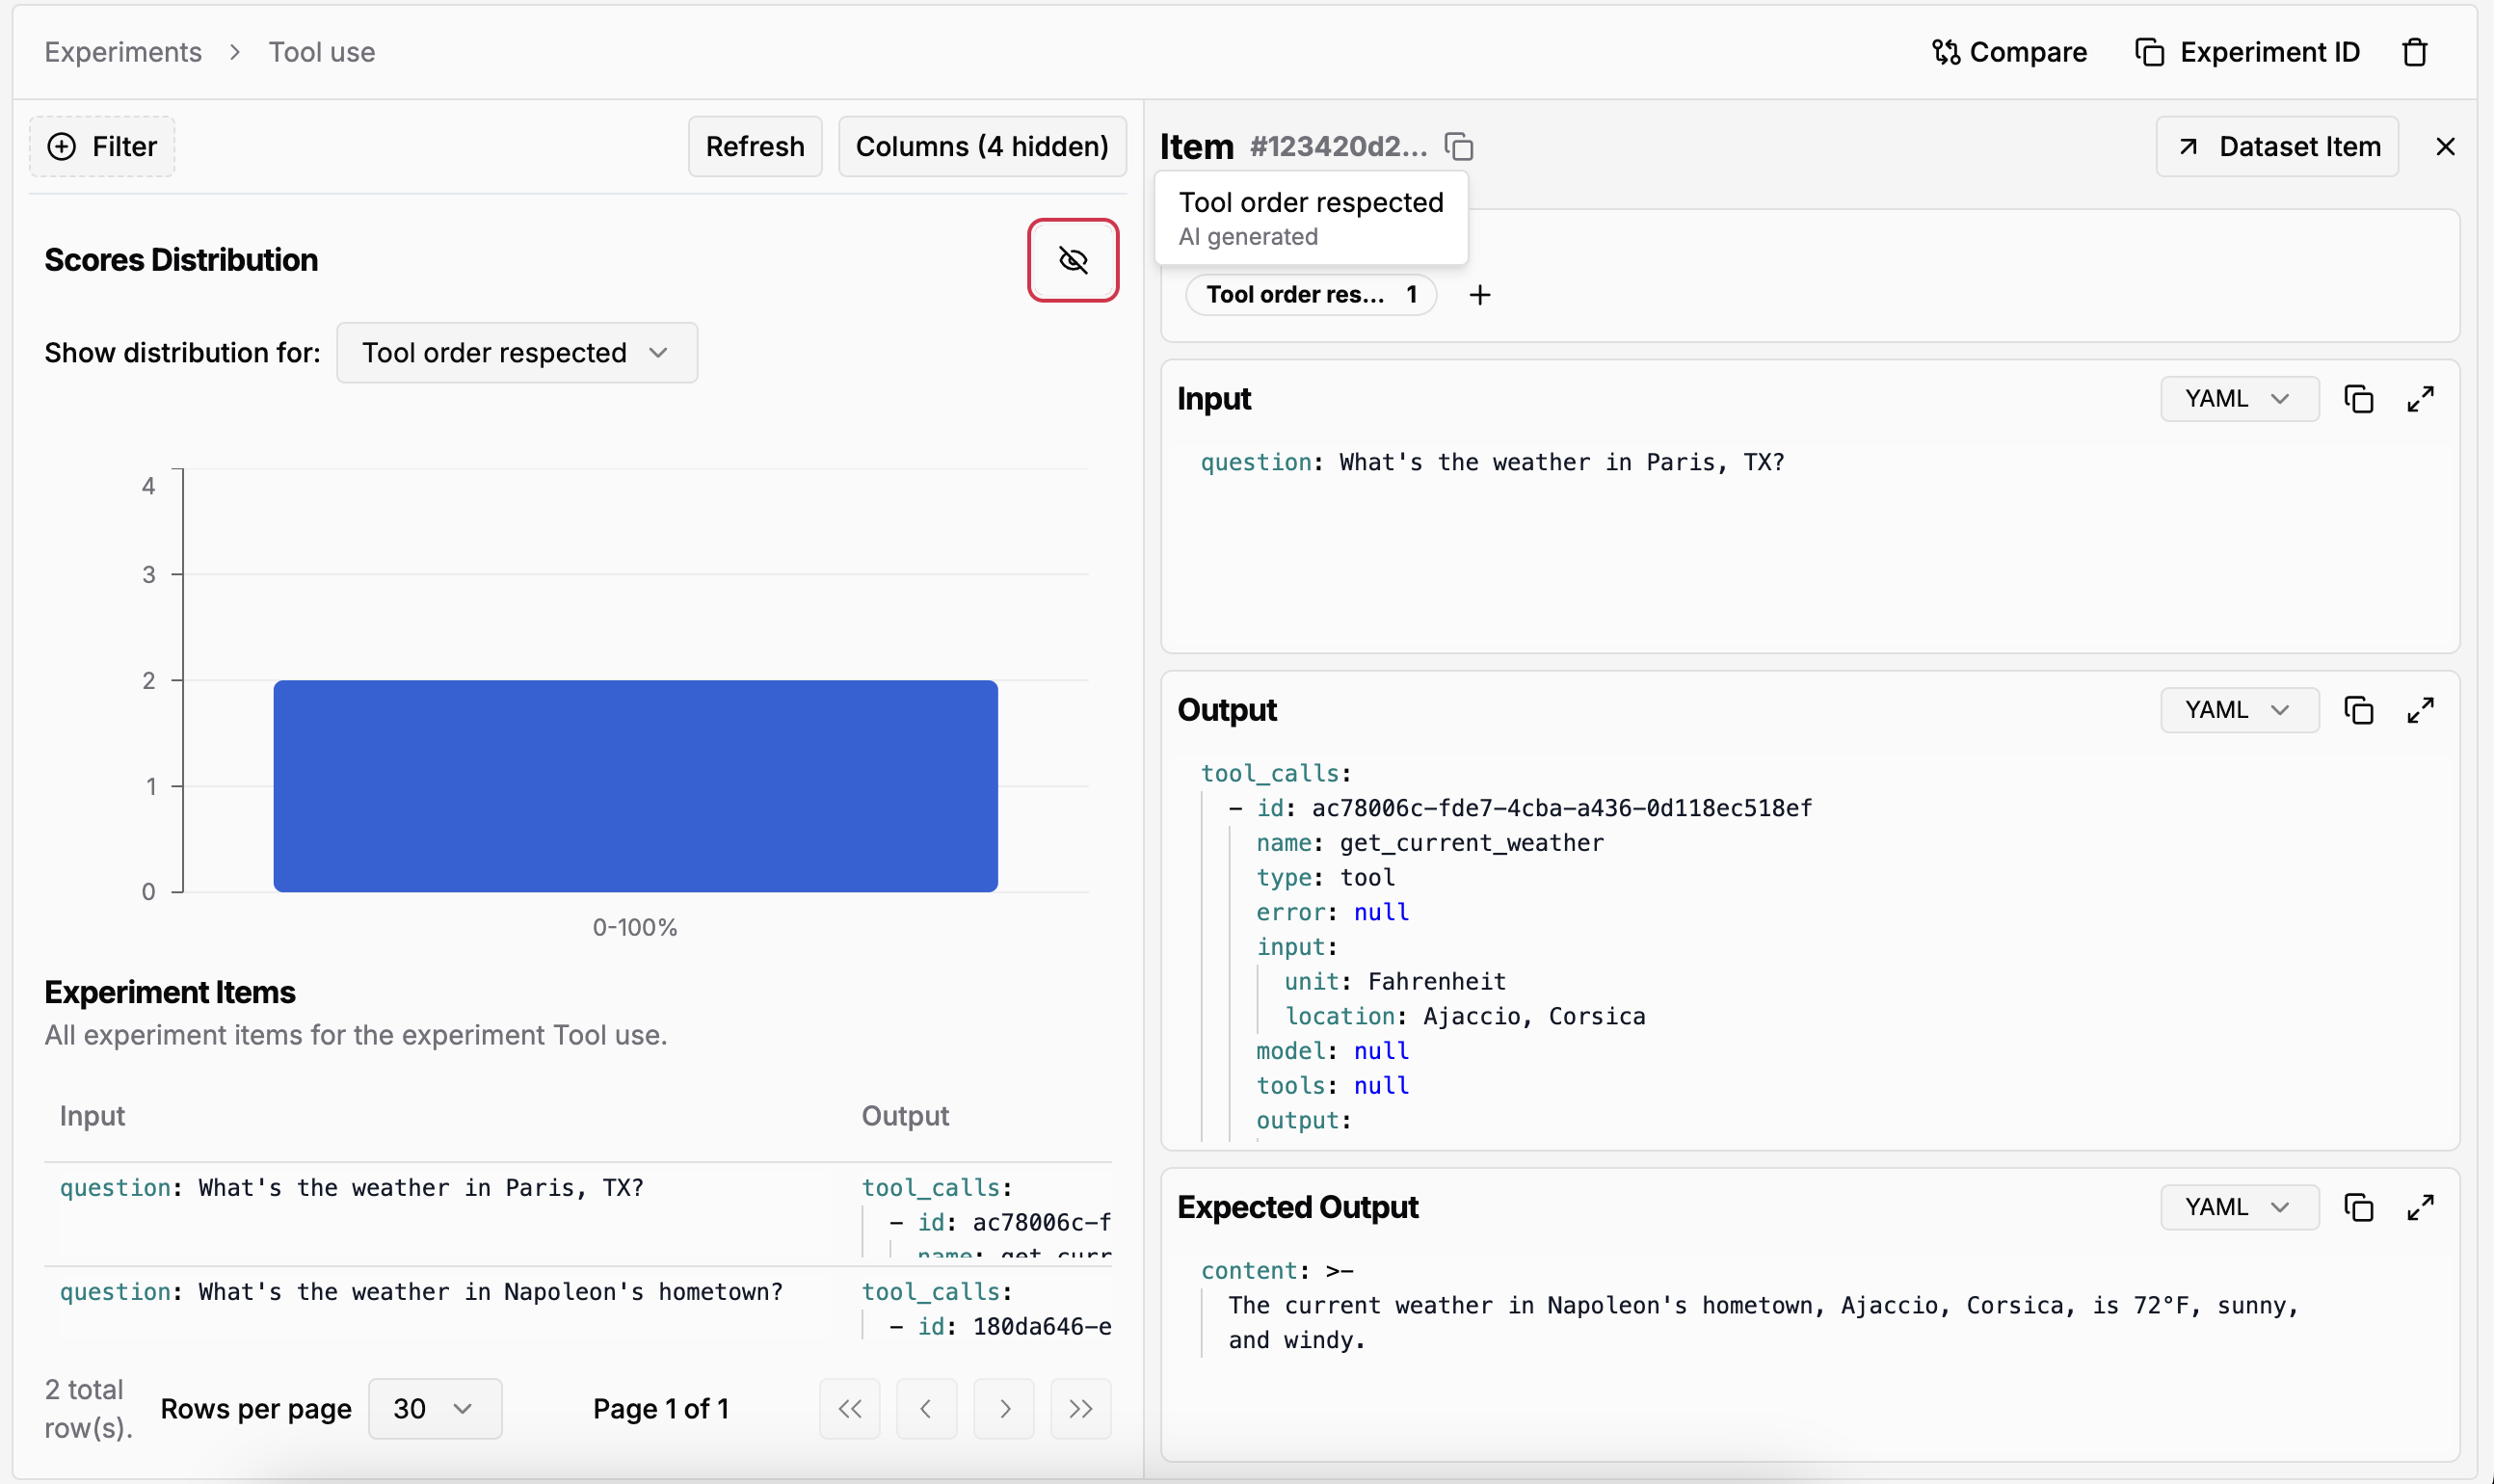